In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

Saving feature_engineered_titanic.csv to feature_engineered_titanic.csv


In [5]:
df = pd.read_csv("feature_engineered_titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,2,2,2
1,2,1,1,0,38.0,1,0,PC 17599,65.6344,0,2,3
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,2,1,1
3,4,1,1,0,35.0,1,0,113803,53.1000,2,2,3
4,5,0,3,1,35.0,0,0,373450,8.0500,2,1,2


In [16]:
df.drop(columns=["Ticket"], errors="ignore", inplace=True)

In [17]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [18]:
X = df.drop("Survived", axis=1)
X.select_dtypes(exclude=["number"]).columns

Index([], dtype='object')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [22]:
svm = SVC(probability=True, kernel="rbf")
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:, 1]

In [23]:
def evaluate_model(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

In [24]:
results = pd.DataFrame({
    "Logistic Regression": evaluate_model(y_test, y_pred_lr, y_prob_lr),
    "Random Forest": evaluate_model(y_test, y_pred_rf, y_prob_rf),
    "SVM": evaluate_model(y_test, y_pred_svm, y_prob_svm)
})

results

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Logistic Regression,Random Forest,SVM
Accuracy,0.804469,0.832402,0.614525
Precision,0.783333,0.830508,0.000000
Recall,0.681159,0.710145,0.000000
F1-Score,0.728682,0.765625,0.000000
ROC-AUC,0.848617,0.861660,0.646245


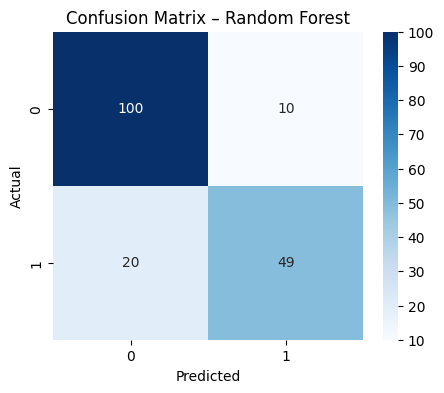

In [25]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()

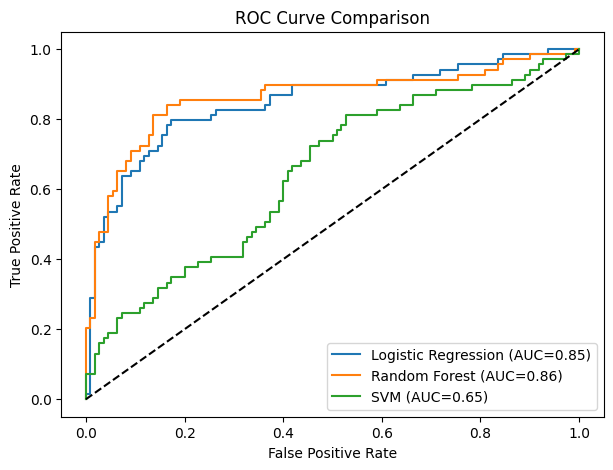

In [26]:
plt.figure(figsize=(7,5))

for model_name, y_prob in zip(
    ["Logistic Regression", "Random Forest", "SVM"],
    [y_prob_lr, y_prob_rf, y_prob_svm]
):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [27]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6, 8],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

grid.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}

In [28]:
best_rf = grid.best_estimator_

best_rf.fit(X_train, y_train)

y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_best, y_prob_best)

{'Accuracy': 0.8212290502793296,
 'Precision': 0.8135593220338984,
 'Recall': 0.6956521739130435,
 'F1-Score': 0.75,
 'ROC-AUC': np.float64(0.856916996047431)}

In [29]:
cv_scores = cross_val_score(
    best_rf, X, y, cv=5, scoring="f1"
)

print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())

Cross-validation F1 scores: [0.75806452 0.76691729 0.76335878 0.7008547  0.8030303 ]
Mean F1 score: 0.7584451183746145


In [30]:
import joblib
joblib.dump(best_rf, "best_titanic_model.pkl")

['best_titanic_model.pkl']

In [32]:
from google.colab import files
files.download("best_titanic_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
import joblib

# Save preprocessing columns
MODEL_FEATURES = X.columns.tolist()
joblib.dump(MODEL_FEATURES, "model_features.pkl")

['model_features.pkl']

In [34]:
from google.colab import files
files.download("model_features.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>